# 加载基本依赖库

In [1]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

# 1. 注册自己coco格式的数据集：
按照 Detectron2 自定义数据集教程，将自己的数据集注册到 Detectron2

In [2]:
from detectron2.data.datasets import register_coco_instances

In [3]:
register_coco_instances('lslm_coco_train', {}, 
                        '/home/workspace/bolt_nut/datasets/annotations/lslm_train.json', 
                       '/home/workspace/bolt_nut/datasets/lslm')

获取数据的元数据

In [4]:
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
coco_lslm_train_metadata = MetadataCatalog.get("lslm_coco_train")
train_dataset_dicts = DatasetCatalog.get("lslm_coco_train")
coco_lslm_train_metadata

[03/28 15:03:50 d2.data.datasets.coco]: Loaded 409 images in COCO format from /home/workspace/bolt_nut/datasets/annotations/lslm_train.json


Metadata(evaluator_type='coco', image_root='/home/workspace/bolt_nut/datasets/lslm', json_file='/home/workspace/bolt_nut/datasets/annotations/lslm_train.json', name='lslm_coco_train', thing_classes=['bolt', 'nut'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1})

原始数据可视化

In [6]:
import random 
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow

/root/anaconda3/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


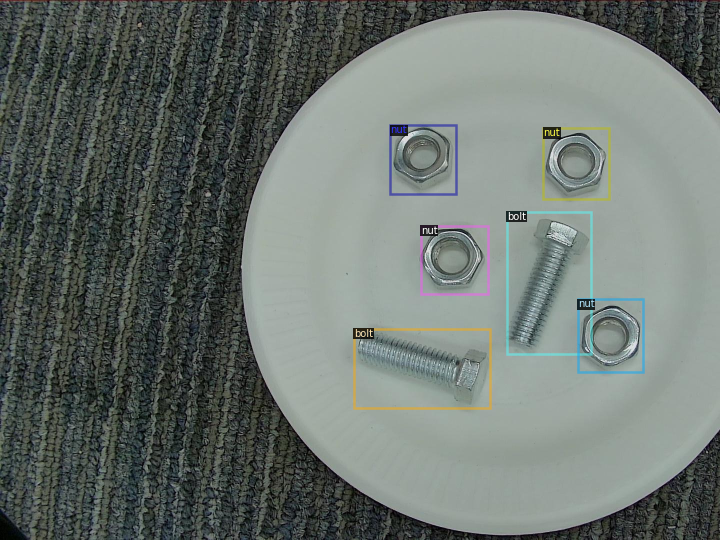

In [7]:
for image in random.sample(train_dataset_dicts, 1):
    img = cv2.imread(image["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=coco_lslm_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(image)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# 模型训练

In [8]:
from detectron2.engine import DefaultTrainer, default_setup
from detectron2.config import get_cfg
from detectron2 import model_zoo

In [9]:
def setup(args):
    """设置基本参数"""
    cfg = get_cfg()
    
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.DATASETS.TRAIN = ("lslm_coco_train", )
    # cfg.DATASETS.TEST = ("lslm_coco_val", )
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    
    # Let training initialize from model zoo
    # cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
    cfg.MODEL.WEIGHTS = args.model_weights
    cfg.OUTPUT_DIR = args.output_dir
    
    cfg.SOLVER.IMS_PER_BATCH = 2
    # pick a good LR
    cfg.SOLVER.BASE_LR = 0.00025 
    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
    cfg.SOLVER.MAX_ITER = 1000 
    # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
    # coco datasets(bolt, nut)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  
    
    cfg.freeze()
    default_setup(cfg, args)
    
    return cfg

In [10]:
import argparse 

In [11]:
parser = argparse.ArgumentParser(description="LSLM train for builtin models")
parser.add_argument(
    "--config-file",
    default="/home/workspace/bolt_nut/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    metavar="FILE",
    help="path to config file",
    )
parser.add_argument(
    "--model-weights", 
    default="/home/workspace/bolt_nut/models/R-50.pkl", 
    type=str, 
    help="Initial weights path.", 
    )
parser.add_argument(
    "--output-dir", 
    default="/home/workspace/bolt_nut/models", 
    type=str, 
    help="Outpu weights save path.", 
    )
parser.add_argument(
    "--opts",
    help="Modify config options using the command-line 'KEY VALUE' pairs",
    default=[],
    nargs=argparse.REMAINDER,
    )

_StoreAction(option_strings=['--opts'], dest='opts', nargs='...', const=None, default=[], type=None, choices=None, help="Modify config options using the command-line 'KEY VALUE' pairs", metavar=None)

In [12]:
args = parser.parse_args(args=[])
print(args.output_dir)

/home/workspace/bolt_nut/models


In [13]:
cfg = setup(args)
cfg

[03/28 15:04:07 detectron2]: Rank of current process: 0. World size: 1
[03/28 15:04:07 detectron2]: Rank of current process: 0. World size: 1
[03/28 15:04:08 detectron2]: Environment info:
------------------------  --------------------------------------------------------------
sys.platform              linux
Python                    3.7.4 (default, Aug 13 2019, 20:35:49) [GCC 7.3.0]
numpy                     1.17.2
detectron2                0.1.1 @/root/anaconda3/lib/python3.7/site-packages/detectron2
detectron2 compiler       GCC 7.4
detectron2 CUDA compiler  10.1
detectron2 arch flags     sm_70
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0 @/root/anaconda3/lib/python3.7/site-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0,1,2,3,4,5,6,7       Tesla V100-PCIE-32GB
CUDA_HOME                 /usr/local/cuda
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    6.2.0
torchvision       

[03/28 15:04:08 detectron2]: Running with full config:
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ('lslm_coco_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATUR

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': '/home/workspace/bolt_nut/models/R-50.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 

In [14]:
import os 

In [15]:
def main(cfg):
    """
    训练模型
    """
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

开始训练模型

In [16]:
main(cfg)

[03/28 15:04:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/28 15:04:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/28 15:04:21 d2.data.datasets.coco]: Loaded 409 images in COCO format from /home/workspace/bolt_nut/datasets/annotations/lslm_train.json
[03/28 15:04:21 d2.data.datasets.coco]: Loaded 409 images in COCO format from /home/workspace/bolt_nut/datasets/annotations/lslm_train.json
[03/28 15:04:21 d2.data.build]: Removed 0 images with no usable annotations. 409 images left.
[03/28 15:04:21 d2.data.build]: Removed 0 images with no usable annotations. 409 images left.
[03/28 15:04:21 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    bolt    | 1492         |    nut     | 1439         |
|            |              |            |              |
|   total    | 2931         |            |              |
[03/28 15:04:21 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-----

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.shortcut.norm.running_mean loaded from res2_0_branch1_bn_running_mean    of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.shortcut.norm.running_var  loaded from res2_0_branch1_bn_running_var     of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.shortcut.norm.running_var  loaded from res2_0_branch1_bn_running_var     of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.shortcut.norm.weight       loaded from res2_0_branch1_bn_gamma           of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.shortcut.norm.weight       loaded from res2_0_branch1_bn_gamma           of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.shortcut.weight            loaded from res2_0_branch1_w                  of shape (256, 64, 1, 1)
[03/28 

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv2.norm.bias            loaded from res2_2_branch2b_bn_beta           of shape (64,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv2.norm.bias            loaded from res2_2_branch2b_bn_beta           of shape (64,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv2.norm.running_mean    loaded from res2_2_branch2b_bn_running_mean   of shape (64,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv2.norm.running_mean    loaded from res2_2_branch2b_bn_running_mean   of shape (64,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv2.norm.running_var     loaded from res2_2_branch2b_bn_running_var    of shape (64,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.2.conv2.norm.running_var     loaded from res2_2_branch2b_bn_running_var    of shape (64,)
[03/28 15:04:21 d2.che

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.conv3.norm.weight          loaded from res3_0_branch2c_bn_gamma          of shape (512,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.conv3.weight               loaded from res3_0_branch2c_w                 of shape (512, 128, 1, 1)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.conv3.weight               loaded from res3_0_branch2c_w                 of shape (512, 128, 1, 1)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.shortcut.norm.bias         loaded from res3_0_branch1_bn_beta            of shape (512,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.shortcut.norm.bias         loaded from res3_0_branch1_bn_beta            of shape (512,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.0.shortcut.norm.running_mean loaded from res3_0_branch1_bn_running_mean    of shape (51

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv1.norm.running_var     loaded from res3_2_branch2a_bn_running_var    of shape (128,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv1.norm.running_var     loaded from res3_2_branch2a_bn_running_var    of shape (128,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv1.norm.weight          loaded from res3_2_branch2a_bn_gamma          of shape (128,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv1.norm.weight          loaded from res3_2_branch2a_bn_gamma          of shape (128,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv1.weight               loaded from res3_2_branch2a_w                 of shape (128, 512, 1, 1)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.2.conv1.weight               loaded from res3_2_branch2a_w                 of shape (128, 512, 1,

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.bias            loaded from res3_3_branch2c_bn_beta           of shape (512,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.running_mean    loaded from res3_3_branch2c_bn_running_mean   of shape (512,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.running_mean    loaded from res3_3_branch2c_bn_running_mean   of shape (512,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.running_var     loaded from res3_3_branch2c_bn_running_var    of shape (512,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.running_var     loaded from res3_3_branch2c_bn_running_var    of shape (512,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.3.conv3.norm.weight          loaded from res3_3_branch2c_bn_gamma          of shape (512,)
[03/28 15:04:21 

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.0.shortcut.weight            loaded from res4_0_branch1_w                  of shape (1024, 512, 1, 1)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.0.shortcut.weight            loaded from res4_0_branch1_w                  of shape (1024, 512, 1, 1)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv1.norm.bias            loaded from res4_1_branch2a_bn_beta           of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv1.norm.bias            loaded from res4_1_branch2a_bn_beta           of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv1.norm.running_mean    loaded from res4_1_branch2a_bn_running_mean   of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.1.conv1.norm.running_mean    loaded from res4_1_branch2a_bn_running_mean   of shape (

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.norm.running_var     loaded from res4_2_branch2b_bn_running_var    of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.norm.weight          loaded from res4_2_branch2b_bn_gamma          of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.norm.weight          loaded from res4_2_branch2b_bn_gamma          of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.weight               loaded from res4_2_branch2b_w                 of shape (256, 256, 3, 3)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.weight               loaded from res4_2_branch2b_w                 of shape (256, 256, 3, 3)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv3.norm.bias            loaded from res4_2_branch2c_bn_beta           of shape (10

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.running_mean    loaded from res4_4_branch2a_bn_running_mean   of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.running_mean    loaded from res4_4_branch2a_bn_running_mean   of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.running_var     loaded from res4_4_branch2a_bn_running_var    of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.running_var     loaded from res4_4_branch2a_bn_running_var    of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.weight          loaded from res4_4_branch2a_bn_gamma          of shape (256,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.4.conv1.norm.weight          loaded from res4_4_branch2a_bn_gamma          of shape (256,)
[03/28 15:04:21 

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.5.conv2.weight               loaded from res4_5_branch2b_w                 of shape (256, 256, 3, 3)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.5.conv3.norm.bias            loaded from res4_5_branch2c_bn_beta           of shape (1024,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.5.conv3.norm.bias            loaded from res4_5_branch2c_bn_beta           of shape (1024,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.5.conv3.norm.running_mean    loaded from res4_5_branch2c_bn_running_mean   of shape (1024,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.5.conv3.norm.running_mean    loaded from res4_5_branch2c_bn_running_mean   of shape (1024,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.5.conv3.norm.running_var     loaded from res4_5_branch2c_bn_running_var    of shape (1024,)
[

[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.shortcut.norm.weight       loaded from res5_0_branch1_bn_gamma           of shape (2048,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.shortcut.norm.weight       loaded from res5_0_branch1_bn_gamma           of shape (2048,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.shortcut.weight            loaded from res5_0_branch1_w                  of shape (2048, 1024, 1, 1)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.0.shortcut.weight            loaded from res5_0_branch1_w                  of shape (2048, 1024, 1, 1)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv1.norm.bias            loaded from res5_1_branch2a_bn_beta           of shape (512,)
[03/28 15:04:21 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv1.norm.bias            loaded from res5_1_branch2a_bn_beta           of sha

[03/28 15:04:22 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.conv2.norm.running_mean    loaded from res5_2_branch2b_bn_running_mean   of shape (512,)
[03/28 15:04:22 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.conv2.norm.running_var     loaded from res5_2_branch2b_bn_running_var    of shape (512,)
[03/28 15:04:22 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.conv2.norm.running_var     loaded from res5_2_branch2b_bn_running_var    of shape (512,)
[03/28 15:04:22 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.conv2.norm.weight          loaded from res5_2_branch2b_bn_gamma          of shape (512,)
[03/28 15:04:22 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.conv2.norm.weight          loaded from res5_2_branch2b_bn_gamma          of shape (512,)
[03/28 15:04:22 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.2.conv2.weight               loaded from res5_2_branch2b_w                 of shape (512, 512, 3, 3)
[03/28

[03/28 15:04:32 d2.utils.events]:  eta: 0:02:35  iter: 59  total_loss: 1.658  loss_cls: 0.437  loss_box_reg: 0.504  loss_rpn_cls: 0.678  loss_rpn_loc: 0.092  time: 0.1643  data_time: 0.0039  lr: 0.000015  max_mem: 2307M
[03/28 15:04:35 d2.utils.events]:  eta: 0:02:34  iter: 79  total_loss: 1.708  loss_cls: 0.432  loss_box_reg: 0.499  loss_rpn_cls: 0.662  loss_rpn_loc: 0.077  time: 0.1650  data_time: 0.0037  lr: 0.000020  max_mem: 2307M
[03/28 15:04:35 d2.utils.events]:  eta: 0:02:34  iter: 79  total_loss: 1.708  loss_cls: 0.432  loss_box_reg: 0.499  loss_rpn_cls: 0.662  loss_rpn_loc: 0.077  time: 0.1650  data_time: 0.0037  lr: 0.000020  max_mem: 2307M
[03/28 15:04:38 d2.utils.events]:  eta: 0:02:29  iter: 99  total_loss: 1.907  loss_cls: 0.447  loss_box_reg: 0.713  loss_rpn_cls: 0.642  loss_rpn_loc: 0.070  time: 0.1642  data_time: 0.0037  lr: 0.000025  max_mem: 2307M
[03/28 15:04:38 d2.utils.events]:  eta: 0:02:29  iter: 99  total_loss: 1.907  loss_cls: 0.447  loss_box_reg: 0.713  loss

[03/28 15:05:32 d2.utils.events]:  eta: 0:01:37  iter: 419  total_loss: 0.799  loss_cls: 0.134  loss_box_reg: 0.569  loss_rpn_cls: 0.044  loss_rpn_loc: 0.042  time: 0.1663  data_time: 0.0038  lr: 0.000105  max_mem: 2307M
[03/28 15:05:35 d2.utils.events]:  eta: 0:01:34  iter: 439  total_loss: 0.813  loss_cls: 0.177  loss_box_reg: 0.559  loss_rpn_cls: 0.042  loss_rpn_loc: 0.054  time: 0.1661  data_time: 0.0033  lr: 0.000110  max_mem: 2307M
[03/28 15:05:35 d2.utils.events]:  eta: 0:01:34  iter: 439  total_loss: 0.813  loss_cls: 0.177  loss_box_reg: 0.559  loss_rpn_cls: 0.042  loss_rpn_loc: 0.054  time: 0.1661  data_time: 0.0033  lr: 0.000110  max_mem: 2307M
[03/28 15:05:39 d2.utils.events]:  eta: 0:01:30  iter: 459  total_loss: 0.770  loss_cls: 0.184  loss_box_reg: 0.533  loss_rpn_cls: 0.034  loss_rpn_loc: 0.042  time: 0.1663  data_time: 0.0035  lr: 0.000115  max_mem: 2307M
[03/28 15:05:39 d2.utils.events]:  eta: 0:01:30  iter: 459  total_loss: 0.770  loss_cls: 0.184  loss_box_reg: 0.533 

[03/28 15:06:32 d2.utils.events]:  eta: 0:00:37  iter: 779  total_loss: 0.658  loss_cls: 0.145  loss_box_reg: 0.464  loss_rpn_cls: 0.013  loss_rpn_loc: 0.036  time: 0.1661  data_time: 0.0037  lr: 0.000195  max_mem: 2307M
[03/28 15:06:35 d2.utils.events]:  eta: 0:00:33  iter: 799  total_loss: 0.563  loss_cls: 0.132  loss_box_reg: 0.407  loss_rpn_cls: 0.013  loss_rpn_loc: 0.035  time: 0.1661  data_time: 0.0038  lr: 0.000200  max_mem: 2307M
[03/28 15:06:35 d2.utils.events]:  eta: 0:00:33  iter: 799  total_loss: 0.563  loss_cls: 0.132  loss_box_reg: 0.407  loss_rpn_cls: 0.013  loss_rpn_loc: 0.035  time: 0.1661  data_time: 0.0038  lr: 0.000200  max_mem: 2307M
[03/28 15:06:38 d2.utils.events]:  eta: 0:00:30  iter: 819  total_loss: 0.551  loss_cls: 0.136  loss_box_reg: 0.374  loss_rpn_cls: 0.010  loss_rpn_loc: 0.031  time: 0.1661  data_time: 0.0040  lr: 0.000205  max_mem: 2307M
[03/28 15:06:38 d2.utils.events]:  eta: 0:00:30  iter: 819  total_loss: 0.551  loss_cls: 0.136  loss_box_reg: 0.374 

# detectron2多GPU训练参考